In [1]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchaudio.transforms as T
import torchvision.models as models
import torch.optim.lr_scheduler as lr_scheduler
import pandas as pd
import torch.nn as nn
from tqdm import tqdm
import os
import time
import datetime


from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

import config

In [2]:
#Load the Dataloader for this task
from DL_Autoencoder import DL_auto as DL

## Models

In [3]:




# Define your Autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Define encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), 
            nn.ReLU()
        )
        
        # Define decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x





In [4]:
class Autoencoder2deeper(nn.Module):
    def __init__(self):
        super(Autoencoder2deeper, self).__init__()
        # Define encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
        )
        
        # Define decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
            
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [5]:

class Autoencoder2deeperDO(nn.Module):
    def __init__(self):
        super(Autoencoder2deeperDO, self).__init__()

        # Encoder
        self.enc_conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.enc_conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.enc_conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.enc_conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.dropout1 = nn.Dropout(0.5)

        # Decoder
        self.dec_conv1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=(1, 0))
        self.dec_bn1 = nn.BatchNorm2d(64)
        self.dec_conv2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=(1, 0))
        self.dec_bn2 = nn.BatchNorm2d(32)
        self.dec_conv3 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=(1, 0))
        self.dec_bn3 = nn.BatchNorm2d(16)
        self.dec_conv4 = nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=(1, 1))
        self.dropout2 = nn.Dropout(0.5)

    def forward(self, x):
        # Encoder
        x = F.relu(self.bn1(self.enc_conv1(x)))
        x = F.relu(self.bn2(self.enc_conv2(x)))
        x = F.relu(self.bn3(self.enc_conv3(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn4(self.enc_conv4(x)))

        # Decoder
        x = F.relu(self.dec_bn1(self.dec_conv1(x)))
        x = self.dropout2(x)
        x = F.relu(self.dec_bn2(self.dec_conv2(x)))
        x = F.relu(self.dec_bn3(self.dec_conv3(x)))
        x = torch.sigmoid(self.dec_conv4(x))

        return x

In [6]:

class ResNetAutoencoder(nn.Module):
    def __init__(self,target_size=501):
        super(ResNetAutoencoder, self).__init__()

        # Load pre-trained ResNet-50
        resnet = models.resnet50(pretrained=True)

        # Remove the fully connected layers
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])
        self.target_size = target_size
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2048, 1024, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=2, stride=2),
            nn.ReLU(inplace=True)  # Use Sigmoid for normalizing the output to [0,1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = F.adaptive_avg_pool2d(x, (128, self.target_size))  # adapt to your target size
        return x


In [7]:


class Autoencoder2deeperDO(nn.Module):
    def __init__(self):
        super(Autoencoder2deeperDO, self).__init__()

        # Encoder
        self.enc_conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.enc_conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.enc_conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.enc_conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.enc_conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.dropout1 = nn.Dropout(0.5)

        # Decoder
        self.dec_conv1 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=(1, 0))
        self.dec_bn1 = nn.BatchNorm2d(128)
        self.dec_conv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=(1, 0))
        self.dec_bn2 = nn.BatchNorm2d(64)
        self.dec_conv3 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=(1, 0))
        self.dec_bn3 = nn.BatchNorm2d(32)
        self.dec_conv4 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=(1, 0))
        self.dec_bn4 = nn.BatchNorm2d(16)
        self.dec_conv5 = nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=(1, 1))
        self.dropout2 = nn.Dropout(0.5)

    def forward(self, x):
        # Encoder
        x = F.relu(self.bn1(self.enc_conv1(x)))
        x = F.relu(self.bn2(self.enc_conv2(x)))
        x = F.relu(self.bn3(self.enc_conv3(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn4(self.enc_conv4(x)))
        x = F.relu(self.bn5(self.enc_conv5(x)))

        # Decoder
        x = F.relu(self.dec_bn1(self.dec_conv1(x)))
        x = self.dropout2(x)
        x = F.relu(self.dec_bn2(self.dec_conv2(x)))
        x = F.relu(self.dec_bn3(self.dec_conv3(x)))
        x = F.relu(self.dec_bn4(self.dec_conv4(x)))
        x = torch.sigmoid(self.dec_conv5(x))

        return x


In [8]:
# initialize the DataLoader
train_loader, val_loader = DL.create_generators()

Number of files:  39887
True Value:  True
Number of files:  4431
True Value:  True


## Test Plot of Maked and real Spectrogram

torch.Size([128, 376])
torch.Size([32, 3, 128, 376])


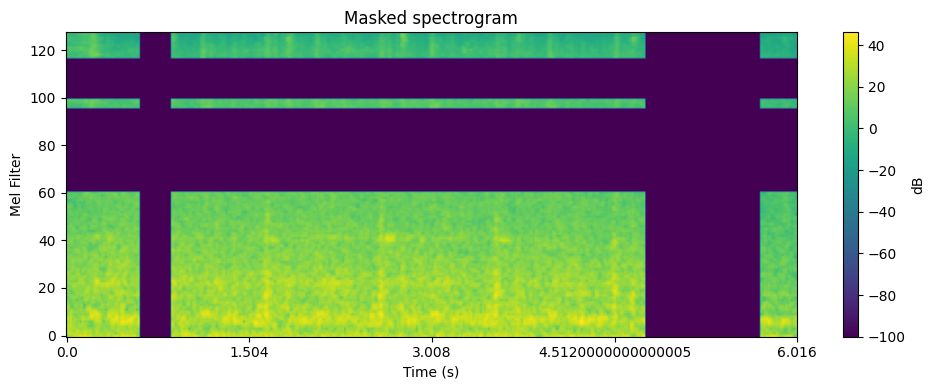

torch.Size([128, 376])
torch.Size([32, 3, 128, 376])


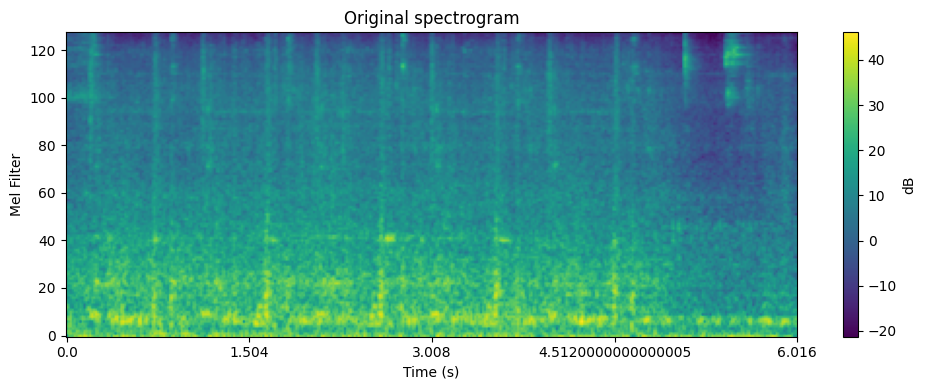

In [9]:
data1, data2 = next(iter(train_loader))

def plot_mel_spectrogram(melspe_db, sample_rate, hop_length, name):
    plt.figure(figsize=(10, 4))

    melspe_db_single = melspe_db[0, 0, :, :].squeeze()

    print(melspe_db_single.shape)
    print(melspe_db.shape)

    if melspe_db_single.ndim != 2:
        raise ValueError("melspe_db_single should be a 2D array")

    # Convert tensor data to numpy for visualization
    melspe_db_np = melspe_db_single.cpu().detach().numpy()

    # Display the spectrogram
    plt.imshow(melspe_db_np, cmap='viridis', origin='lower', aspect='auto')
    plt.ylabel('Mel Filter')
    plt.xlabel('Time (s)')
    plt.colorbar(label='dB')
    plt.title(name)

    # Adjust x-axis to show time in seconds
    num_time_bins = melspe_db_np.shape[1]
    plt.xticks(np.linspace(0, num_time_bins, 5), 
               np.linspace(0, num_time_bins * hop_length / sample_rate, 5))

    plt.tight_layout()
    plt.show()

# Call the function with the modified data
plot_mel_spectrogram(data1, sample_rate=32000, hop_length=512,name="Masked spectrogram")
plot_mel_spectrogram(data2, sample_rate=32000, hop_length=512,name="Original spectrogram")

### Model initalisation

In [10]:
data1,_ = next(iter(train_loader))

# set the target size
target_size = data1.shape[3]
print(target_size)

# Instantiate model, loss function, and optimizer
#model = Autoencoder()
#model = Autoencoder2deeper()
#model = Autoencoder2deeperDO()
model = ResNetAutoencoder(target_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, verbose=True)

# Move model to CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
val_losses = []

# Training loop
num_epochs = config.epochs



376


c:\Users\Gabriel\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Gabriel\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:

patience = config.patience 
best_val_loss = float('inf')  
epochs_no_improve = 0  

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for mel_spec_masked, mel_spec in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        mel_spec_masked = mel_spec_masked.to(device)
        mel_spec = mel_spec.to(device)

        optimizer.zero_grad()

        outputs = model(mel_spec_masked)
        _, _, H, W = outputs.size()
        mel_spec = mel_spec[..., :H, :W]

        loss = criterion(outputs, mel_spec)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    average_train_loss = train_loss / len(train_loader)
    train_losses.append(average_train_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for mel_spec_masked, mel_spec in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            mel_spec_masked = mel_spec_masked.to(device)
            mel_spec = mel_spec.to(device)

            outputs = model(mel_spec_masked)
            _, _, H, W = outputs.size()
            mel_spec = mel_spec[..., :H, :W]

            loss = criterion(outputs, mel_spec)
            val_loss += loss.item()

    average_val_loss = val_loss / len(val_loader)
    val_losses.append(average_val_loss)

    #early stopping
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        epochs_no_improve = 0
        print(f'Best validation loss: {best_val_loss:.4f}')
    else:
        epochs_no_improve += 1
        print(f'Epochs with no improvement: {epochs_no_improve}')

    if epochs_no_improve == patience:
        print('Early stopping!' )
        break

    


    lr_scheduler.step(val_losses[-1])

    # Print losses
    print(f'Epoch {epoch+1}, Average Train Loss: {average_train_loss:.4f}, Average Val Loss: {average_val_loss:.4f}')

#save whole model

#model = torch.load('./results/res_auto/resNet_autoen_model.pth')
#model.target_size = target_size

Epoch 1/200 - Training:   3%|▎         | 33/1247 [00:14<08:51,  2.28it/s]


KeyboardInterrupt: 

In [ ]:
torch.save(model, './results/res_auto/resNetTry23_11_autoen_model.pth')


Number of files:  39887
True Value:  True
Number of files:  4431
True Value:  True
torch.Size([128, 376])
torch.Size([1, 3, 128, 376])


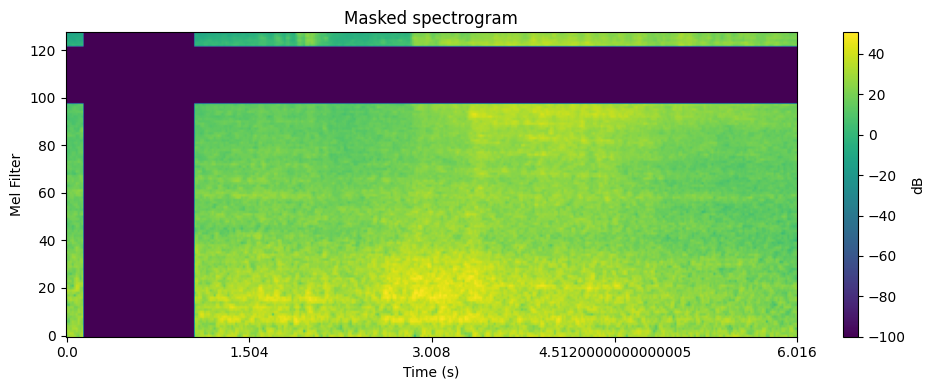

torch.Size([128, 376])
torch.Size([1, 3, 128, 376])


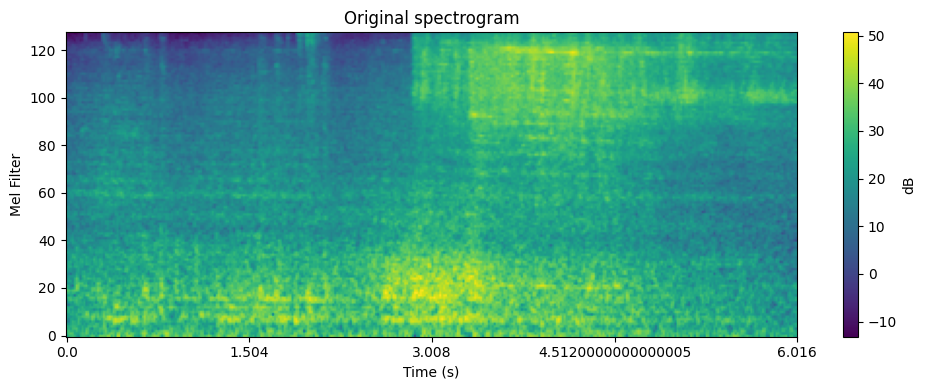

torch.Size([128, 376])
torch.Size([1, 3, 128, 376])


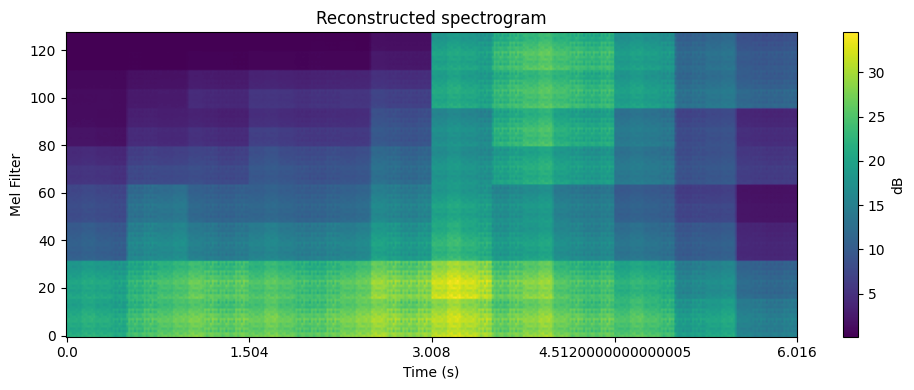

In [12]:

config.batch_size = 1
train_loader, val_loader = DL.create_generators()


#d3elete cuda cache
torch.cuda.empty_cache()
data1, data2 = next(iter(val_loader))
outputs = model(data1)


plot_mel_spectrogram(data1, sample_rate=32000, hop_length=512,name="Masked spectrogram")
plot_mel_spectrogram(data2, sample_rate=32000, hop_length=512,name="Original spectrogram")
plot_mel_spectrogram(outputs, sample_rate=32000, hop_length=512,name="Reconstructed spectrogram")
config.batch_size = 64

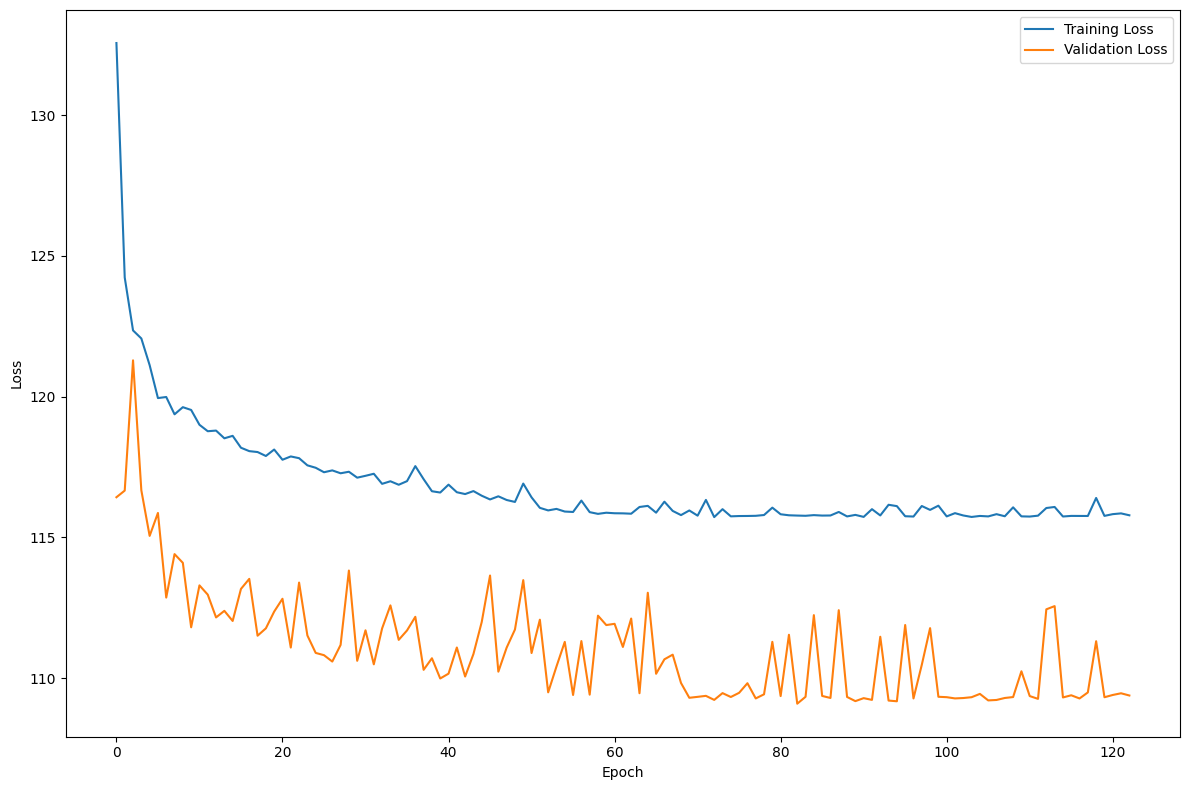

In [ ]:
#plot loss
plt.figure(figsize=(12, 8))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()
